In [ ]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.model_analyzer import perform_model_analysis

from CICIDS2017.preprocessing.dataset import CICIDS2017
from UNSWNB15.preprocessing.dataset import UNSWNB15


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
lm = LoggerManager(log_dir=f"{root_dir}/logs", log_name="test_dl_models")
lm.logger.info("Logger initialized")

dataset = CICIDS2017(dataset_size="full",logger=lm.logger).encode(attack_encoder="onehot").scale(scaler="minmax").optimize_memory()


2025-11-18 10:19:05,131 - INFO - Logger initialized
2025-11-18 10:19:05,131 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-18 10:19:05,825 - INFO - Loading data
2025-11-18 10:19:19,693 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-18 10:19:34,299 - INFO - ============================================================
2025-11-18 10:19:34,300 - INFO - Preprocessing completed successfully
2025-11-18 10:19:34,301 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-18 10:19:34,301 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-18 10:19:34,302 - INFO - data retention rate: 87.73%
2025-11-18 10:19:34,302 - INFO - ============================================================
2025-11-18 10:19:34,303 - INFO - Encoding attack labels...
2025-11-18 10:19:35,392 - INFO - Attack labels encoded using OneHotEncoder(sparse_output=False) encoder.
2025-11-18 10:19:35,392 - INFO - Scaling dataset features...
2025-11-18 10:19:59,6

In [3]:
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

def train_nids_model(model, optimizer, scheduler, train_loader, val_loader, device, epochs=25):
    epoch_losses = []
    epoch_val_losses = []
    # Training loop
    tqdm_epochs = tqdm(range(int(epochs)), desc="Training Progress")
    for epoch in tqdm_epochs:
        model.train()
        losses = []
        for X_train, y1_train, y2_train in train_loader:
            # Forward pass
            out1, out2 = model(X_train)
            loss1 = bce_loss(out1, y1_train)
            loss2 = ce_loss(out2, y2_train)
            loss = loss1 + loss2
            losses.append(loss)

        epoch_loss = sum(losses) / len(losses)
        epoch_losses.append(epoch_loss.cpu().detach().numpy())
            
        # Backward pass and optimization
        optimizer.zero_grad()
        epoch_loss.backward()
        optimizer.step()

        scheduler.step(epoch_loss.detach())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X_val, y1_val, y2_val in val_loader:
                val_out1, val_out2 = model(X_val)
                val_loss = bce_loss(val_out1, y1_val) + ce_loss(val_out2, y2_val)
                val_losses.append(val_loss)

            epoch_val_loss = sum(val_losses) / len(val_losses)
            epoch_val_losses.append(epoch_val_loss.cpu().detach().numpy())
            
        tqdm_epochs.set_description(f"Loss: {epoch_loss.item():.4f}, Val Loss: {epoch_val_loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.2e}")

    return model, epoch_losses, epoch_val_losses


In [4]:
def display_loss(list_epoch_loss, list_val_loss, title, dir, logger, epoch_min=2):
    lm.logger.info("Plotting loss curve...")
    # Plotting loss curve with linear and log scale
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(list_epoch_loss[epoch_min:], label='Training Loss')
    plt.plot(list_val_loss[epoch_min:], '-r', label='Validation Loss')
    plt.title(f"Loss Curve - {title}")  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(list_epoch_loss[epoch_min:], label='Training Loss')
    plt.plot(list_val_loss[epoch_min:], '-r', label='Validation Loss') 
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    loss_plot_path = f"{dir}/loss_img/{title}_loss.png"
    os.makedirs(f"{dir}/loss_img", exist_ok=True)
    plt.savefig(loss_plot_path, bbox_inches='tight', dpi=300)
    lm.logger.info(f"Loss curve saved as {loss_plot_path}")
    plt.show()

In [5]:
X = torch.FloatTensor(dataset.scaled_features).to(device)
y1 = torch.FloatTensor(dataset.is_attack).to(device)
y2 = torch.FloatTensor(dataset.attack_classes).to(device)

dataset_size = len(X)

# Randomly get a subset of the data
subset_size = min(50000, dataset_size)
indices = torch.randperm(dataset_size)[:subset_size]
X = X[indices]
y1 = y1[indices]
y2 = y2[indices]


In [6]:
# Display num of elements per class
unique, counts = torch.unique(torch.argmax(y1, dim=1), return_counts=True)
class_distribution = dict(zip(unique.cpu().numpy(), counts.cpu().numpy()))
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

difference = subset_size - sum(counts).item()
print(f"Class 'benign' (0): {difference} samples")

Class 0: 39250 samples
Class 1: 10750 samples
Class 'benign' (0): 0 samples


In [7]:
# Display num of elements per class
unique, counts = torch.unique(torch.argmax(y2, dim=1), return_counts=True)
class_distribution = dict(zip(unique.cpu().numpy(), counts.cpu().numpy()))
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class 0: 39250 samples
Class 1: 52 samples
Class 2: 3344 samples
Class 3: 4979 samples
Class 6: 2375 samples


In [8]:
dataset_tensor = TensorDataset(X, y1, y2)

train_size = int(0.8 * len(dataset_tensor))
val_size = len(dataset_tensor) - train_size

print(f"Dataset size: {len(dataset_tensor)}, Train size: {train_size}, Val size: {val_size}")

Dataset size: 50000, Train size: 40000, Val size: 10000


In [9]:
train_dataset, val_dataset = random_split(dataset_tensor, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [11]:
input_size = dataset.scaled_features.shape[1]
num_classes = len(dataset.attack_classes[0])
print(f"Input size: {input_size}, Num classes: {num_classes}")

Input size: 70, Num classes: 7


In [12]:
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

In [13]:
class NetworkIntrusionMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetworkIntrusionMLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        self.classifier1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, num_classes[0]),
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(64 + num_classes[0], 32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, num_classes[1]),
        )
        
        self.proj = nn.Linear(input_size, num_classes[0])

    def forward(self, x):
        features = self.features(x)
        out1 = self.classifier1(features) + self.proj(x)
        # Combine features and out1 for second classifier
        x2 = torch.cat((features, out1), dim=1)
        out2 = self.classifier2(x2)
        return torch.softmax(out1, dim=1), torch.softmax(out2, dim=1)

In [14]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=[2, num_classes]).to(device)
num_parameters = sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)
print(f"Number of trainable parameters in MLP model: {num_parameters}")

learning_rate_mlp = 1e-2
num_epochs_mlp = 100

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=8, min_lr=1e-6)

Number of trainable parameters in MLP model: 26679


In [15]:
model_mlp, train_losses_mlp, val_losses_mlp = train_nids_model(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)

Loss: 1.3127, Val Loss: 1.3112, LR: 8.00e-03: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


2025-11-18 10:22:23,748 - INFO - Plotting loss curve...
2025-11-18 10:22:24,522 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/MLP_NIDS_loss.png


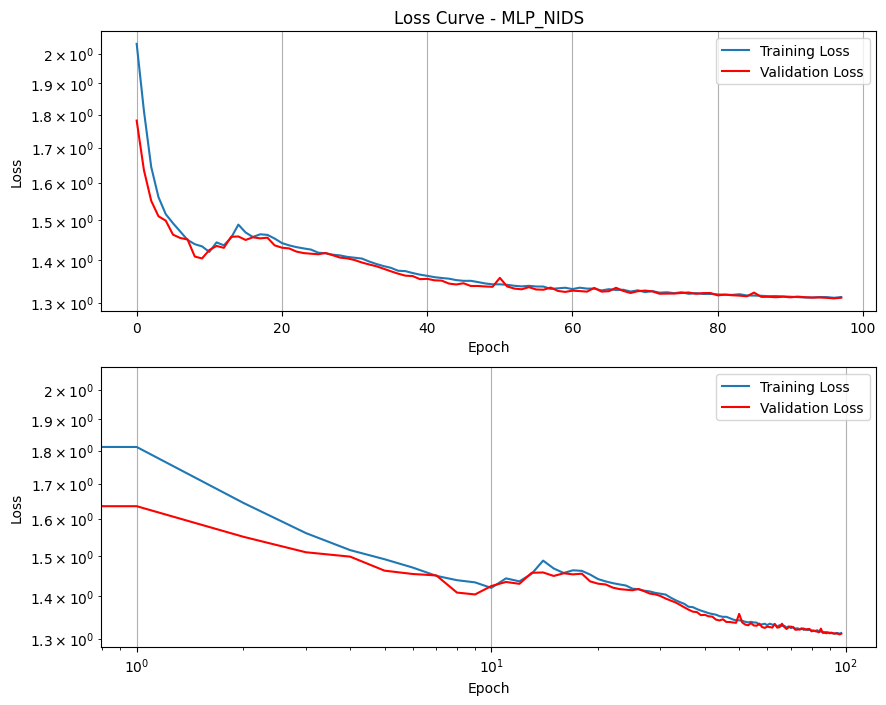

In [16]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title="MLP_NIDS",
    dir=root_dir,
    logger=lm.logger,
    epoch_min=2
)

2025-11-18 10:22:24,858 - INFO - Running analysis for PyTorch model: MLP_NIDS on device: cuda:0
2025-11-18 10:22:26,102 - INFO - Detected multi-output model with 2 outputs
2025-11-18 10:22:26,118 - INFO - 
--- Classification Report for MLP_NIDS - Output 1 ---
              precision    recall  f1-score   support

           0     0.9878    0.9723    0.9800     39250
           1     0.9042    0.9563    0.9295     10750

    accuracy                         0.9688     50000
   macro avg     0.9460    0.9643    0.9547     50000
weighted avg     0.9699    0.9688    0.9691     50000


/home/alexin/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alexin/Docu

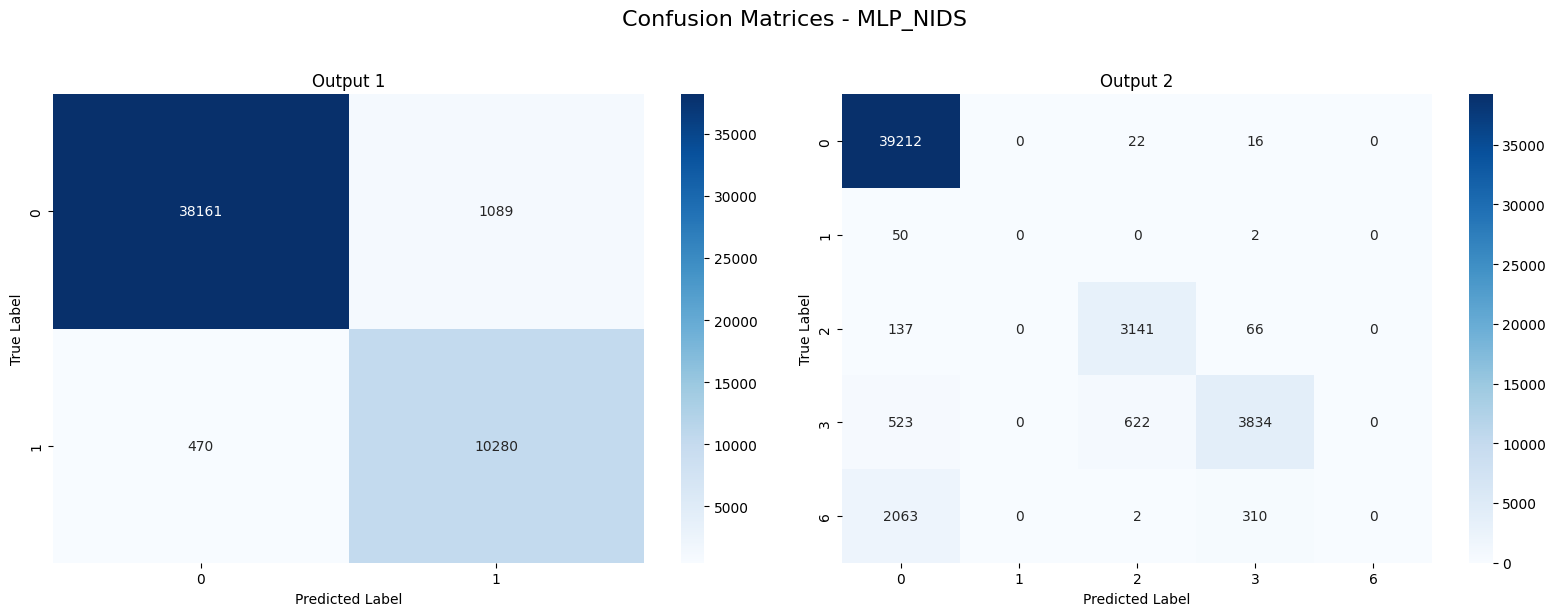

In [18]:
perform_model_analysis(
    model=model_mlp,
    X_test=X,
    y_test=[y1, y2],
    logger=lm.logger,
    model_name="MLP_NIDS",
    device=device
)